# Downloading data of reddit comments

In [ ]:
$sudo wget http://files.pushshift.io/reddit/comments/RC_2018-02.xz
#Size of RC_2018-02 is 56 GB

In [1]:
import pandas as pd
import json
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark import SQLContext
from pyspark.sql import SparkSession,HiveContext
from pyspark.sql.functions import format_number,mean,max,min,sum,explode,split,regexp_replace,countDistinct,first,year,month,date_format,udf,col,to_date
from pyspark.conf import SparkConf
from pyspark.sql.types import DateType,BooleanType,StringType,FloatType,ArrayType
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

# JSON Parsing

In [32]:
i = 0
fp = open('/data/tg_cg18_bigdata/rc_2018_02.csv', 'w')
fp.write('author,body,created_utc,controversiality,edited,author_flair_css_class,author_flair_text,link_id,parent_id,score\n')
for line in open("/data/tg_cg18_bigdata/RC_2018-02"):
    di =json.loads(line)
    fp.write(di['author'].replace(',','').replace('\n','') + "," + di['body'].replace(',','').replace('\n','') + "," + str(di['created_utc']) + "," + str(di['controversiality']) + "," + str(di['edited']) + "," + str(di['author_flair_css_class']).replace(',','').replace('\n','')+ "," + str(di['author_flair_text']).replace(',','').replace('\n','') + "," + di['link_id'].replace(',','').replace('\n','') + "," + str(di['parent_id']).replace(',','').replace('\n','') + "," + str(di['score']) + "\n")
    i = i + 1
    if i > 10:
        break
fp.close()

# Putting data in hadoop cluster

In [ ]:
$hadoop fs -put /data/tg_cg18_bigdata/rc_2018_02.csv /user/sohom/
#Size of rc_2018_02.csv is 20 GB

# Analyzing data using spark

In [2]:
def create_sc():
    sc_conf = SparkConf()
    sc_conf.setAppName("app1")
    sc_conf.setMaster('spark://groan81104.timesgroup.com:7077')
    sc_conf.set('spark.executor.memory', '60g')
    sc_conf.set('spark.executor.cores', '8')
    sc_conf.set('spark.cores.max', '16')
    sc_conf.set('spark.logConf', True)
    print (sc_conf.getAll())

    sc = None
    try:
        sc.stop()
        sc = SparkContext(conf=sc_conf)
    except:
        sc = SparkContext(conf=sc_conf)

    return sc

In [3]:
spark = create_sc()

dict_items([('spark.app.name', 'app1'), ('spark.master', 'spark://groan81104.timesgroup.com:7077'), ('spark.executor.memory', '60g'), ('spark.executor.cores', '8'), ('spark.cores.max', '16'), ('spark.logConf', 'True')])


In [4]:
##For creating SQL context / Derby
#sp = SQLContext(spark)

In [4]:
spark_hive = HiveContext(spark)

In [5]:
##For loading data using SQL context / Debry
#reddit_comments_data = sp.read.csv('/user/sohom/rc_2018_02.csv', header=True, mode="DROPMALFORMED", inferSchema = True)

In [5]:
reddit_comments_data = spark_hive.read.csv('/user/sohom/rc_2018_02.csv', header=True, mode="DROPMALFORMED", inferSchema = True)

In [6]:
reddit_comments_data.show(10)

+--------------------+--------------------+-----------+----------------+------+----------------------+-----------------+---------+----------+-----+
|              author|                body|created_utc|controversiality|edited|author_flair_css_class|author_flair_text|  link_id| parent_id|score|
+--------------------+--------------------+-----------+----------------+------+----------------------+-----------------+---------+----------+-----+
|YouthfulPhotographer|Welcome to genera...| 1517443200|               0| False|                  None|             None|t3_7uaobc|t1_dtj8323|    7|
|        jasonklacour|             Welcome| 1517443200|               0| False|                  None|             None|t3_7ude45| t3_7ude45|    1|
|        Assassin2000|I'm 16 and the fr...| 1517443200|               0| False|                  None|             None|t3_7uegdc|t1_dtjo9qq|    1|
|         kawaiicicle|What? It’s a nich...| 1517443200|               0| False|              Employee|Assistant 

## Finding total number of entries / rows

In [58]:
reddit_comments_data.count()

86406074

## Finding unique number of authors

In [49]:
reddit_comments_data.select('author').distinct().count()

4282253

## Finding types of controversiality

In [51]:
reddit_comments_data.groupby('controversiality').count().orderBy('count', ascending = False).show(100, truncate = False)

+----------------+--------+
|controversiality|count   |
+----------------+--------+
|0               |84488433|
|1               |1917641 |
+----------------+--------+



## Finding time distribution of edited articles

In [52]:
reddit_comments_data.groupby('edited').count().orderBy('count', ascending = False).show(100, truncate = False)

+----------+--------+
|edited    |count   |
+----------+--------+
|False     |83868809|
|1518141178|25      |
|1518410104|25      |
|1519055294|23      |
|1518708044|22      |
|1518466892|12      |
|1519055593|12      |
|1518708139|12      |
|1520260157|11      |
|1519765317|11      |
|1518618709|11      |
|1519504861|10      |
|1518030138|9       |
|1518728128|9       |
|1518724361|9       |
|1518646929|9       |
|1518113565|9       |
|1519253253|9       |
|1519767977|9       |
|1519839080|9       |
|1519535942|9       |
|1518469503|9       |
|1518469502|9       |
|1519151128|9       |
|1518726510|9       |
|1518819809|8       |
|1519832658|8       |
|1517863244|8       |
|1519141037|8       |
|1518708123|8       |
|1518116419|8       |
|1518212814|8       |
|1519158604|8       |
|1519676447|8       |
|1517938094|8       |
|1518554124|8       |
|1519180741|8       |
|1519062093|8       |
|1519842684|8       |
|1518566145|8       |
|1519846901|8       |
|1519311737|8       |
|151975911

## Exploring distribution of author_flair_css_class

In [53]:
reddit_comments_data.groupby('author_flair_css_class').count().orderBy('count', ascending = False).show(100, truncate = False)

+-------------------------------+--------+
|author_flair_css_class         |count   |
+-------------------------------+--------+
|None                           |62588801|
|null                           |2990260 |
|default                        |436244  |
|noflair                        |209008  |
|Training                       |145900  |
|MAL                            |132827  |
|flair-default                  |114083  |
|MURICA                         |113267  |
|us                             |87667   |
|blue                           |81823   |
|xbox                           |78766   |
|patriots                       |70442   |
|eagles                         |67765   |
|green                          |67216   |
|treadonme                      |63018   |
|male                           |62953   |
|female                         |60880   |
|new                            |56818   |
|purple                         |55029   |
|red                            |54224   |
|psn       

## Exploring distribution of author_flair_text

In [55]:
reddit_comments_data.groupby('author_flair_text').count().orderBy('count', ascending = False).show(100, truncate = False)

+--------------------------------------------------+--------+
|author_flair_text                                 |count   |
+--------------------------------------------------+--------+
|None                                              |62348037|
|null                                              |4964536 |
|Text                                              |101912  |
|Patriots                                          |70850   |
|16                                                |70494   |
|Eagles                                            |67988   |
|United States                                     |63204   |
|New User                                          |60957   |
|Lakers                                            |57486   |
|Raptors                                           |52634   |
|TOR - NHL                                         |50746   |
|Cavaliers                                         |50722   |
|Canada                                            |49045   |
|Liverpo

## Finding unique numebr of link_id s

In [57]:
reddit_comments_data.select('link_id').distinct().count()

6438717

## Finding distribution of link_id s

In [56]:
reddit_comments_data.groupby('link_id').count().orderBy('count', ascending = False).show(100, truncate = False)

+---------+------+
|link_id  |count |
+---------+------+
|t3_7yd4sz|517035|
|t3_7y3j4v|108136|
|t3_7vb5tk|55926 |
|t3_7ui180|50222 |
|t3_7xkstl|47542 |
|t3_7vad8n|46261 |
|t3_7x8us7|40492 |
|t3_7zepcu|35548 |
|t3_7vf2ng|34385 |
|t3_7xhsal|30117 |
|t3_7vu5pj|27557 |
|t3_7yir80|27173 |
|t3_808vmz|26966 |
|t3_7wcnvi|26698 |
|t3_7ux0w7|26304 |
|t3_7xqg0q|24358 |
|t3_7vg63x|24162 |
|t3_7x639l|24099 |
|t3_7ubs3f|23994 |
|t3_8042i7|23253 |
|t3_80phz7|22465 |
|t3_7wxdm8|22067 |
|t3_7wl7m0|22002 |
|t3_7yv9cz|21977 |
|t3_7y0ldo|21835 |
|t3_7flk39|21821 |
|t3_80ow6w|21652 |
|t3_7xae0a|21311 |
|t3_7w43k9|20854 |
|t3_7usv0k|20511 |
|t3_7vahxf|20500 |
|t3_7zbgq9|20257 |
|t3_7vwkqg|19761 |
|t3_7yj8zx|19659 |
|t3_7w6ic2|19409 |
|t3_7yaiw6|19307 |
|t3_7xvumf|19293 |
|t3_7vbv3l|18626 |
|t3_7zkpxv|17465 |
|t3_7xsuvk|17015 |
|t3_7xfn4g|16748 |
|t3_7v9yqa|16708 |
|t3_7wi1g8|16648 |
|t3_7ydlf8|15756 |
|t3_7xmtjj|15712 |
|t3_7weo8t|15215 |
|t3_7zomgr|15181 |
|t3_7w392v|15099 |
|t3_7zafwi|15077 |
|t3_7ygb2e|1

## Finding unique number of parent_id s

In [60]:
reddit_comments_data.select('parent_id').distinct().count()

42619735

## Finding distribution of parent_id s

In [59]:
reddit_comments_data.groupby('parent_id').count().orderBy('count', ascending = False).show(100, truncate = False)

+---------+-----+
|parent_id|count|
+---------+-----+
|t3_7vb5tk|39842|
|t3_7vad8n|34131|
|t3_7yir80|20069|
|t3_808vmz|19510|
|t3_7vahxf|15511|
|t3_7vf2ng|15436|
|t3_7w43k9|13360|
|t3_7zqhlg|11761|
|t3_80ow6w|11625|
|t3_7zbgq9|11074|
|t3_7x8us7|10256|
|t3_7yay78|10028|
|t3_7v9yqa|9668 |
|t3_7vg8eh|9172 |
|t3_7zepcu|8881 |
|t3_7ygb2e|8829 |
|t3_80phz7|8734 |
|t3_7flk39|8549 |
|t3_7w392v|8492 |
|t3_7woy83|8471 |
|t3_7wsmg6|8455 |
|t3_80c1b2|8025 |
|t3_7xsuvk|7914 |
|t3_7wn71y|7523 |
|t3_80i3mq|7455 |
|t3_7xqg0q|7247 |
|t3_7vvp34|7029 |
|t3_7vg63x|6889 |
|t3_7yvhmi|6740 |
|t3_7vbv3l|6634 |
|t3_7yi156|6619 |
|t3_7yro04|6619 |
|t3_7vmv0p|6577 |
|t3_7yxgfz|6524 |
|t3_7z96md|6519 |
|t3_7zzdvu|6357 |
|t3_7wcnvi|6304 |
|t3_7yaiw6|6233 |
|t3_7x5jw2|6179 |
|t3_7v2yrz|6080 |
|t3_7wuxco|6071 |
|t3_7x639l|5980 |
|t3_7ui180|5922 |
|t3_7v6qtc|5908 |
|t3_7wdyi4|5821 |
|t3_7xkcfc|5776 |
|t3_7wivf3|5520 |
|t3_7vji65|5514 |
|t3_7vbb0g|5483 |
|t3_7w6ic2|5455 |
|t3_7wl7m0|5375 |
|t3_7vsuyj|5146 |
|t3_7wvkwb

## Score distribution : min, mean, max

In [65]:
reddit_comments_data.orderBy('score', ascending = False).select('score').show(10)

+-----+
|score|
+-----+
|60272|
|57978|
|49127|
|48327|
|46687|
|44436|
|44412|
|44266|
|43576|
|42742|
+-----+
only showing top 10 rows



In [66]:
reddit_comments_data.orderBy('score').select('score').show(10)

+-----+
|score|
+-----+
|-7632|
|-2113|
|-1992|
|-1883|
|-1862|
|-1696|
|-1693|
|-1691|
|-1654|
|-1569|
+-----+
only showing top 10 rows



In [67]:
reddit_comments_data.select(max("score")).show(truncate=False)

+----------+
|max(score)|
+----------+
|60272     |
+----------+



In [68]:
reddit_comments_data.select(min("score")).show(truncate=False)

+----------+
|min(score)|
+----------+
|-7632     |
+----------+



In [69]:
reddit_comments_data.select(mean("score")).show(truncate=False)

+-----------------+
|avg(score)       |
+-----------------+
|8.893615222003953|
+-----------------+



## Average score per author

In [72]:
reddit_comments_data.groupBy('author').agg({'score': 'mean'}).orderBy('avg(score)', ascending = False).show()

+----------------+------------------+
|          author|        avg(score)|
+----------------+------------------+
|       Aardvarkm|           44266.0|
|      byrneeoinm|           29619.0|
| YuckierAlmond16|           26164.0|
|      vickster23|           24211.0|
|          jomrib|           24159.0|
|    discovery_as|           22325.0|
|SingularityThrow|           19436.0|
|        CoachWar|           17549.0|
|  Hector_Moseley|           17087.0|
|      Ebonyarnes|           16423.0|
|     papatrudeau|           15698.0|
|         krifter|           14170.5|
|    spaghettttti|12740.333333333334|
|   EwellTremblay|           12719.0|
|          syerik|           12677.0|
|     Tanyaendoza|           12570.0|
|     dwarvenmonk|           12567.0|
| CongressmanAkin|           11553.0|
|       nolava006|           11492.0|
|    KnightforceX|           11092.5|
+----------------+------------------+
only showing top 20 rows



## Authors with highest average score

In [73]:
reddit_comments_data.groupBy('author').agg({'score': 'mean'}).orderBy('avg(score)', ascending = False).show()

+----------------+------------------+
|          author|        avg(score)|
+----------------+------------------+
|       Aardvarkm|           44266.0|
|      byrneeoinm|           29619.0|
| YuckierAlmond16|           26164.0|
|      vickster23|           24211.0|
|          jomrib|           24159.0|
|    discovery_as|           22325.0|
|SingularityThrow|           19436.0|
|        CoachWar|           17549.0|
|  Hector_Moseley|           17087.0|
|      Ebonyarnes|           16423.0|
|     papatrudeau|           15698.0|
|         krifter|           14170.5|
|    spaghettttti|12740.333333333334|
|   EwellTremblay|           12719.0|
|          syerik|           12677.0|
|     Tanyaendoza|           12570.0|
|     dwarvenmonk|           12567.0|
| CongressmanAkin|           11553.0|
|       nolava006|           11492.0|
|    KnightforceX|           11092.5|
+----------------+------------------+
only showing top 20 rows



## Authors with least average score

In [74]:
reddit_comments_data.groupBy('author').agg({'score': 'mean'}).orderBy('avg(score)').show()

+-------------------+-------------------+
|             author|         avg(score)|
+-------------------+-------------------+
|  nathanielfrankart|             -593.0|
|       PunjabiIdiot|            -435.75|
|   fuckyouquestbots| -427.6666666666667|
|  EasternBackground| -379.0769230769231|
|    Wolf-J-Flywheel|             -371.0|
|       SpandexTerry|             -363.0|
|        AntiDruid69|             -340.0|
|             gjh03c|             -328.7|
|      HipHopsRawest|             -317.0|
|PopularConversation|             -288.0|
|          Hammb0ner|             -268.0|
|  IheartFrankCastle|             -267.0|
|            Elpepee|             -263.0|
|   ResurrectPerfect|             -259.0|
|         Phil_Foden|             -257.0|
|        seal_raider|             -254.0|
|      etsukocyr21qi|             -246.0|
|        goosecucker|             -246.0|
|            nemnonn|             -242.0|
|         Skinder506|-234.33333333333334|
+-------------------+-------------

## Converting created_utc to human redable time stamp using udf

In [8]:
def epoch_to_datetime_convert(epc):
    ans = ''
    try:
        ans = time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(int(str(epc))))[:10]
    except:
        ans = ''
    return ans

In [9]:
date_convertor_udf = udf(epoch_to_datetime_convert, StringType())
reddit_comments_data = reddit_comments_data.withColumn('created_date',date_convertor_udf(reddit_comments_data.created_utc))

## Number of comments per day

In [94]:
reddit_comments_data.groupBy('created_date').count().orderBy('created_date').show(100)

+------------+-------+
|created_date|  count|
+------------+-------+
|  2018-02-01|2236102|
|  2018-02-02|3218517|
|  2018-02-03|2828447|
|  2018-02-04|2672928|
|  2018-02-05|3088230|
|  2018-02-06|3164176|
|  2018-02-07|3281959|
|  2018-02-08|3252789|
|  2018-02-09|3235704|
|  2018-02-10|2849012|
|  2018-02-11|2703179|
|  2018-02-12|2940371|
|  2018-02-13|3182141|
|  2018-02-14|3207624|
|  2018-02-15|3121702|
|  2018-02-16|3221064|
|  2018-02-17|2820885|
|  2018-02-18|3235221|
|  2018-02-19|2935757|
|  2018-02-20|3155683|
|  2018-02-21|3279560|
|  2018-02-22|3276864|
|  2018-02-23|3299897|
|  2018-02-24|2871687|
|  2018-02-25|2751114|
|  2018-02-26|3023099|
|  2018-02-27|3269552|
|  2018-02-28|3301033|
|  2018-03-01| 981777|
+------------+-------+



In [96]:
df_date_vs_count = reddit_comments_data.groupBy('created_date').count().orderBy('created_date').toPandas()

In [97]:
df_date_vs_count.head()

,created_date,count
0,2018-02-01,2236102
1,2018-02-02,3218517
2,2018-02-03,2828447
3,2018-02-04,2672928
4,2018-02-05,3088230


## How average score has varied with time

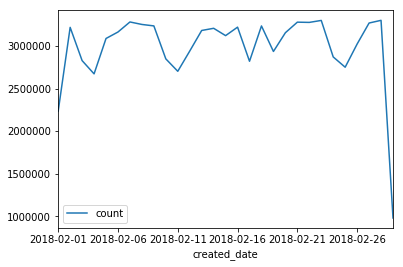

In [101]:
df_date_vs_count.plot(x='created_date', y= "count",kind='line')
plt.show()

## Sentiment Analysis using TextBlob by udf

In [10]:
def sentiment_extraction(text):
    testimonial = TextBlob(str(text))
    ts = testimonial.sentiment
    return ts.polarity
def subjectivity_extraction(text):
    testimonial = TextBlob(str(text))
    ts = testimonial.sentiment
    return ts.subjectivity

In [11]:
senti_udf = udf(sentiment_extraction, FloatType())
subj_udf = udf(subjectivity_extraction, FloatType())

In [12]:
reddit_comments_data = reddit_comments_data.withColumn('sentiment',senti_udf(reddit_comments_data.body))

In [13]:
reddit_comments_data = reddit_comments_data.withColumn('subjectivity',subj_udf(reddit_comments_data.body))

In [14]:
reddit_comments_data.select('body','sentiment','subjectivity').show(10)

+--------------------+-----------+------------+
|                body|  sentiment|subjectivity|
+--------------------+-----------+------------+
|Welcome to genera...|        0.8|         0.9|
|             Welcome|        0.8|         0.9|
|I'm 16 and the fr...|        0.0|         0.0|
|What? It’s a nich...|        0.5|         0.5|
|              solid!|        0.0|         0.1|
|            I agree |        0.0|         0.0|
|Dude its done the...|     -0.275|      0.5125|
|That's what you c...|-0.32777777|  0.64444447|
|           [deleted]|        0.0|         0.0|
|I'm sorry that ha...| 0.12166667|      0.4375|
+--------------------+-----------+------------+
only showing top 10 rows



## Creating Hive Table For connecting with Tableau

In [15]:
reddit_comments_data.createOrReplaceTempView('tmp_reddit_df')

In [16]:
query = spark_hive.sql('create table reddit_comments_data_hive as select * from tmp_reddit_df')
query.show()

++
||
++
++



## Which authors are having maximum average postive sentiment?

In [ ]:
reddit_comments_data.groupBy('author').agg({'sentiment':'mean'}).orderBy('avg(sentiment)', ascending = False).show()

## Which authors are having maximum average subjectivity?

In [ ]:
reddit_comments_data.groupBy('author').agg({'subjectivity':'mean'}).orderBy('avg(sentiment)', ascending = False).show()

## Which authors are having minimum average postive sentiment?

In [ ]:
reddit_comments_data.groupBy('author').agg({'sentiment':'mean'}).orderBy('avg(sentiment)').show()

## Which authors are having minimum average subjectivity?

In [ ]:
reddit_comments_data.groupBy('author').agg({'subjectivity':'mean'}).orderBy('avg(sentiment)').show()

## How average sentiment has varied with time?

In [ ]:
df_date_vs_sentiment = reddit_comments_data.groupBy('created_date').agg({'sentiment':'mean'}).orderBy('created_date').toPandas()
plt.clf()
df_date_vs_sentiment.plot(x='created_date', y= "count",kind='line')
plt.show()

In [ ]:
#Plot is done using Tableau, please refer to slides for details

## How average subjectivity has varied with time?

In [ ]:
df_date_vs_subj = reddit_comments_data.groupBy('created_date').agg({'subjectivity':'mean'}).orderBy('created_date').toPandas()
plt.clf()
df_date_vs_subj.plot(x='created_date', y= "count",kind='line')
plt.show()

In [ ]:
#Plot is done using Tableau, please refer to slides for details

# Future Work

In [ ]:
#[AFTER]
##1) Sentiment analysis using stanford data
# https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
##2) Popular author detection